# Adversarial Attack and Detection in Medical Images using Deap Learning

## Imports
Import common libraries.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Partition data
Partition the data defined in a .csv file, where each row holds the file name of the images and their corresponding label, into three different .csv files; for training, validation and testing. You can specify the ratios of training, validation and test data sets as well as the output directory.

#### Settings

In [2]:
PARTITION = False                             # Set to false once data has been partitioned into .csv files

PARTITION_INPUT_FILE = 'data/data_labels.csv' # File with original images and labels
PARTITION_RATIOS = [0.70, 0.15, 0.15]         # Ratios of training, validation, and test data
PARTITION_UNIFORM = False                     # If to partition data and labels uniformly
PARTITION_OUT_PATH = 'data/2021-11-11/'       # Out path for .csv files for training, validation, and test data

#### Parition data into training, validation, and test data

In [3]:
from data import partition_data

if PARTITION:
    partition_data(input_file=PARTITION_INPUT_FILE,
                   ratios=PARTITION_RATIOS,
                   out_path=PARTITION_OUT_PATH,
                   uniform=PARTITION_UNIFORM)

## Import and transform data
Import the data for training and validation, and augment the images if wanted to. Also plot some examples of training and validation medical images.

#### Settings

In [4]:
COMPUTE_MEAN = False                       # True (compute) or False (use pre-computed), use None use scale to range [-1,1]

IMAGE_SIZE = 400                           # Image size to resize images to
BATCH_SIZE = 16                            # Batch size to use
NUM_WORKERS = 4                            # Number of workers
IMAGE_ROOT = './data/data_images/'         # Path to images
PARTITION_PATH_ROOT = './data/2021-11-05/' # Path to .csv files with training, validation and test data sets

#### Import and transform data

In [5]:
import albumentations as album
from albumentations.pytorch import ToTensorV2
from data import LoadDatasetFromCSV, compute_mean_std
from torch.utils.data import DataLoader



if COMPUTE_MEAN is None:
    data_mean = [0.5,0.5,0.5]
    data_std = [0.5,0.5,0.5]
elif COMPUTE_MEAN is True:
    album_mean_std = album.Compose([album.Resize(IMAGE_SIZE, IMAGE_SIZE),
                                    album.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0], max_pixel_value=255.0),
                                    ToTensorV2()])
    dataset_train = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                       csv_path=PARTITION_PATH_ROOT+'data_labels_train.csv',
                                       transforms=album_mean_std)
    data_mean, data_std = compute_mean_std(dataset_train)
    print('data_mean:', data_mean)
    print('data_std:', data_std)
else:
  # Means and stds for 2021-11-05
    data_mean = torch.tensor([0.7750, 0.5888, 0.7629])
    data_std = torch.tensor([0.2129, 0.2971, 0.1774])
    # Means and stds for 2021-11-11
#     data_mean = torch.tensor([0.7750, 0.5894, 0.7629])
#     data_std = torch.tensor([0.2129, 0.2972, 0.1777])



# Resize images and rescale values
album_compose = album.Compose([
    album.Resize(IMAGE_SIZE, IMAGE_SIZE),                                          # Resize to IMAGE_SIZE x IMAGE_SIZE
    album.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0], max_pixel_value=255.0), # Rescale values from [0,255] to [0,1]
    album.Normalize(mean=data_mean, std=data_std, max_pixel_value=1.0),            # Rescale values according to above
    ToTensorV2(),
])

# Load training and validation data set
dataset_train = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                   csv_path=PARTITION_PATH_ROOT+'data_labels_train.csv',
                                   transforms=album_compose)
dataset_valid = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                   csv_path=PARTITION_PATH_ROOT+'data_labels_validation.csv',
                                   transforms=album_compose)

# Load data into loaders
dataloader_train = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
dataloader_valid = DataLoader(dataset=dataset_valid, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

#### Plot some examples from training and validation data sets

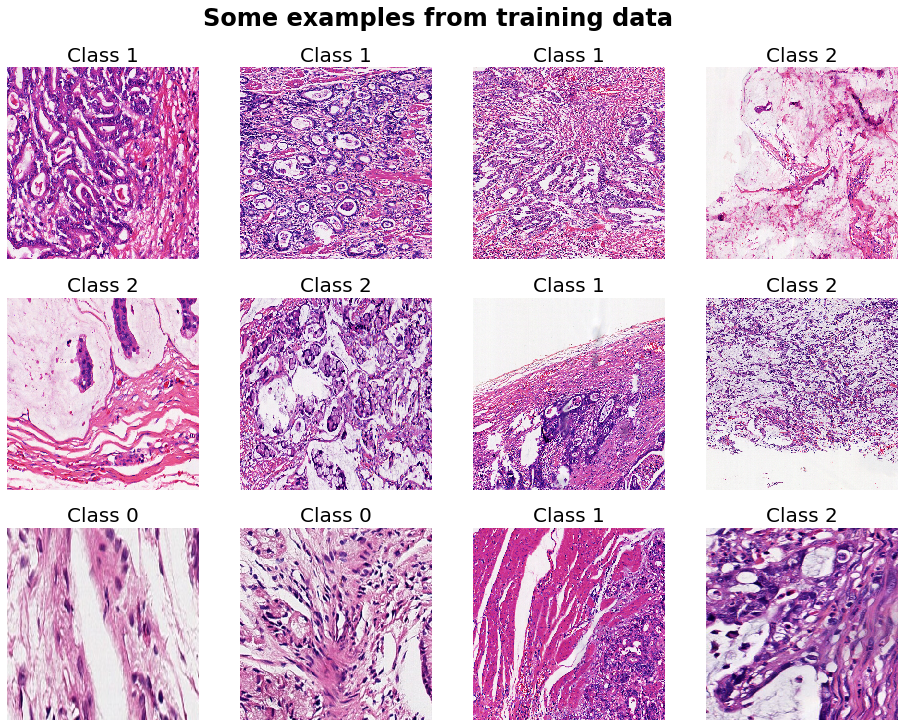

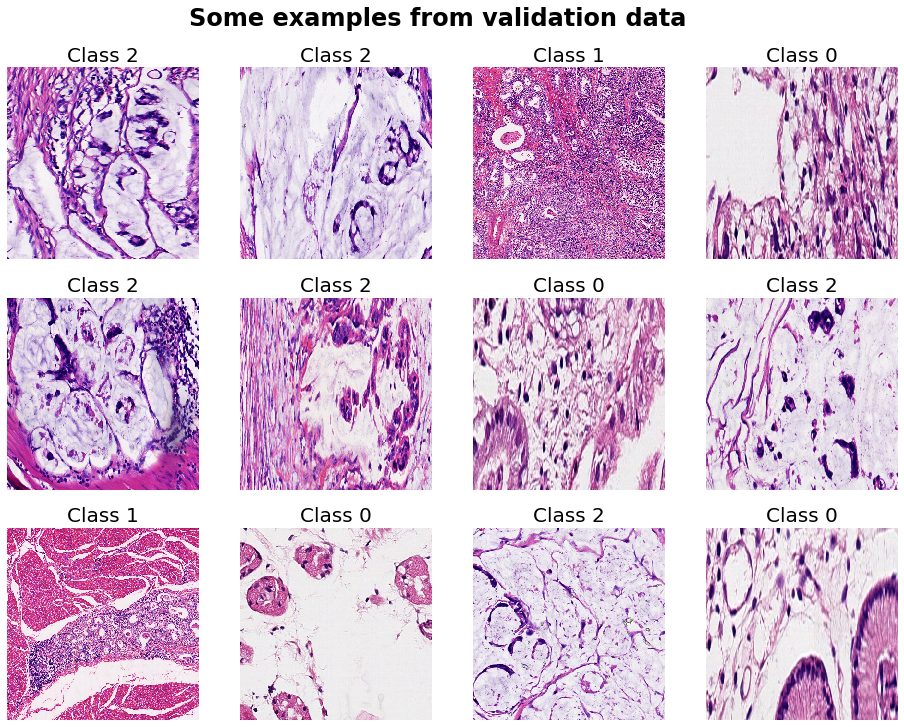

In [6]:
from plot import plot_dataloader

# Plot settings
rows, cols, width = 3, 4, 4

# Plot training data
fig, axs = plot_dataloader(dataloader_train, rows=rows, cols=cols, width=width, mean=data_mean, std=data_std)
fig.suptitle('Some examples from training data', fontsize=24, y=0.95, weight='bold')
plt.show()

# Plot validation data
fig, axs = plot_dataloader(dataloader_valid, rows=rows, cols=cols, width=width, mean=data_mean, std=data_std)
fig.suptitle('Some examples from validation data', fontsize=24, y=0.95, weight='bold')
plt.show()

# Classifier

#### Settings

In [7]:
LOAD_MODEL = True

MODEL_NAME = 'efficientnet-b0'
NUM_CLASSES = 3
EPOCHS = 100
INIT_LR = 0.01
LOAD_PATH = './checkpoints/2021-11-05_400x400_100/models/last.pt'
SAVE_PATH = './checkpoints/2021-11-11_400x400_50'

#### Train classifier

In [8]:
import time
from datetime import datetime, timedelta
from utils import create_save_path
import classify
from models.efficientnet import EfficientNet
from torch.utils.tensorboard import SummaryWriter



# Initialize value for keeping track of "best" model with highest validation accuracy
best_monitor_value = 0



# Load trained model
if LOAD_MODEL:
    
    # Setup
    model = torch.load(LOAD_PATH)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(lr=INIT_LR, params=model.parameters(), betas=(0.9, 0.99))
    
    # Print information
    print('Loaded model:', LOAD_PATH)

    

# Train model
else:
    
    # Setup device, model, loss function, and optimizer
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = EfficientNet.from_name(MODEL_NAME, num_classes=NUM_CLASSES)
    model.to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    loss_function.to(device)
    optimizer = torch.optim.Adam(lr=INIT_LR, params=model.parameters(), betas=(0.9, 0.99))
    optimizer_step = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-5)

    # Create path for saving training log and models
    train_log_path, models_path = create_save_path(SAVE_PATH)

    # Initialize log writer
    log_writer = SummaryWriter(train_log_path, comment=f'LR_{INIT_LR}_BS_{BATCH_SIZE}')

    # Print starting time
    time_start = time.time()
    print('Started training:', str(datetime.now()))
    print('')
    
    # Train for each epoch
    for epoch in range(EPOCHS):
        
        # Print current epoch
        print('Epoch {:<3}'.format(epoch+1), end='   ')
        
        # Train model
        train_acc, train_loss = classify.train(dataloader_train, model, device, loss_function, optimizer)
        print('Training accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*train_acc, 2), np.around(train_loss, 5)), end='   ')

        # Validate model
        valid_acc, valid_loss = classify.valid(dataloader_valid, model, device, loss_function, optimizer)
        print('Validation accuracy: {:>3}%, loss: {:<5}'.format(
            np.around(100*valid_acc, 2), np.around(valid_loss, 5)), end='\n')

        # Optimize
        optimizer_step.step()
        lr = optimizer.param_groups[0]['lr']

        # Save model if better than previously best model as well as the last model
        best_monitor_value = classify.save_model(model=model, epoch=epoch, best_monitor_value=best_monitor_value,
                                               monitor_value=valid_acc, epochs=EPOCHS, models_path=models_path)

        # Write to tensorboard log
        log_writer.add_scalar("Train/Training accuracy",   train_acc,  epoch)
        log_writer.add_scalar("Train/Validation accuracy", valid_acc,  epoch)
        log_writer.add_scalar("Train/Training loss",       train_loss, epoch)
        log_writer.add_scalar("Train/Validation loss",     valid_loss, epoch)
        log_writer.add_scalar("Train/Learning rate",       lr,         epoch)

    # Print time elapsed
    time_elapsed = time.time() - time_start
    print('')
    print('Ended:', str(datetime.now()))
    print('Total training time: {}'.format(str(timedelta(seconds=time_elapsed))))

Loaded model: ./checkpoints/2021-11-05_400x400_100/models/last.pt


## Test classifier

#### Test classifier

In [9]:
# Load test data
dataset_test = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                  csv_path=PARTITION_PATH_ROOT+'data_labels_test.csv',
                                  transforms=album_compose)

# Load data into loaders
dataloader_test = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Test classifier
test_acc, test_loss, misclassified_images, misclassified_labels, correct_labels = \
    classify.test(dataloader_test, model, device, loss_function, optimizer)

print('Test accuracy:   '+str(np.around(100*test_acc,2))+'%')
print('Test loss:       '+str(np.around(test_loss,5)))

Test accuracy:   96.24%
Test loss:       0.1837


#### Plot misclassified examples

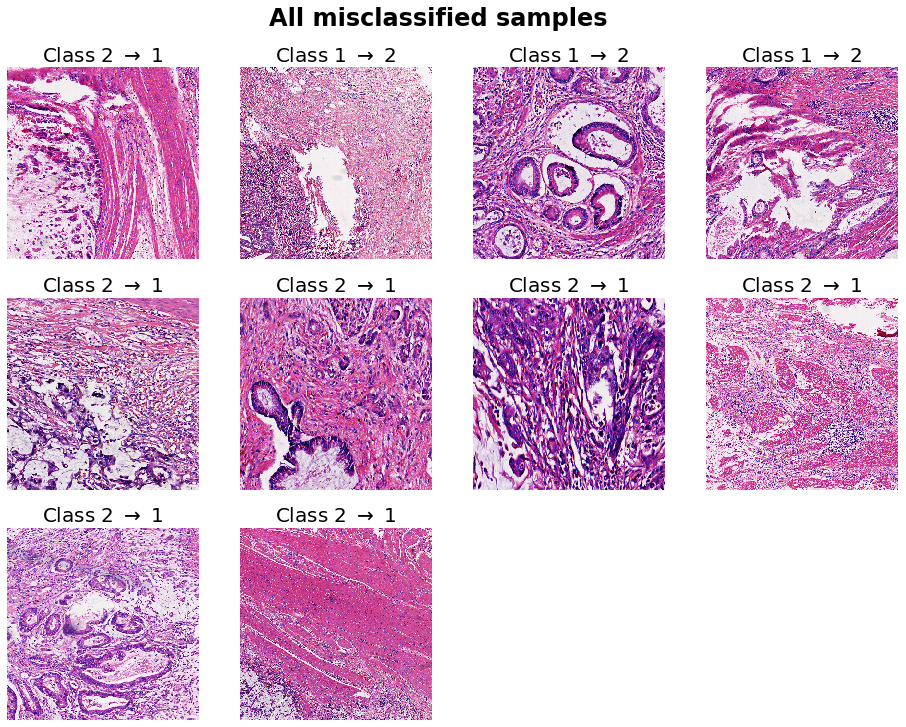

In [10]:
from plot import plot_images

# Plot settings
rows, cols, width = 3, 4, 4

# Plot training data
fig, axs = plot_images(misclassified_images, correct_labels, rows=rows, cols=cols, width=width,
                       mean=data_mean, std=data_std, predicted_labels=misclassified_labels)
fig.suptitle('All misclassified samples', fontsize=24, y=0.95, weight='bold')
plt.show()

# Attack

#### Settings

In [9]:
BATCH_SIZE = 1
SHUFFLE = False
EPSILON_PER_STEP = 0.002
STEPS = 100           # Maximum number of steps if threshold or until_attacked is used 
EPSILON = EPSILON_PER_STEP * STEPS
TARGETED = True
MAX_BATCHES = None    # Set to None if attacking all images
ATTACK_METHOD = 'IFGSM'
THRESHOLD = None      # Set to None if no threshold
UNTIL_ATTACKED = True # If to attack until misclassified
COMPARE_ORIG = True

#### Attack with FGSM or IFGSM

In [ ]:
import attack
from plot import plot_attacks



# Load trained model
model = torch.load(LOAD_PATH)
    
# Load test data to attack
dataset_attack = LoadDatasetFromCSV(image_root=IMAGE_ROOT,
                                    csv_path=PARTITION_PATH_ROOT+'data_labels_test.csv',
                                    transforms=album_compose)

# Load data into loaders
dataloader_attack = DataLoader(dataset=dataset_attack, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Initialize and choose attacker
if ATTACK_METHOD == 'FGSM':
    attack_method = attack.FGSM(model=model, mean=data_mean, std=data_std,
                                epsilon=EPSILON, targeted=TARGETED)
elif ATTACK_METHOD == 'IFGSM':
    attack_method = attack.IFGSM(model= model, mean=data_mean, std=data_std,
                                 epsilon=EPSILON, steps=STEPS, targeted=TARGETED,
                                 threshold=THRESHOLD, until_attacked=UNTIL_ATTACKED,
                                 compare_orig=COMPARE_ORIG)

    
# Intialize reults arrays
all_images = torch.Tensor()
all_labels = torch.Tensor().type(dtype=torch.uint8)
all_init_labels = torch.Tensor().type(dtype=torch.uint8)
all_attacked_images = torch.Tensor()
all_attacked_labels = torch.Tensor().type(dtype=torch.uint8)
all_gradients = torch.Tensor()
all_epsilons = torch.Tensor()
all_steps = torch.Tensor()
if TARGETED:
    all_targeted_labels = torch.Tensor().type(dtype=torch.uint8)
else:
    all_targeted_labels = None
all_similarities = torch.Tensor()


# Iterate over each batch
print('Starting attacks', end='')
for batch, (images, labels) in enumerate(dataloader_attack):
    
    images = images['image']
    init_labels = model(images).max(1, keepdim=False)[1]

    # Attack images
    attacked_images, attacked_labels, gradients, targeted_labels, similarities, epsilons, steps = \
        attack_method.attack(images, labels)
    
    # Concatenate results for each batch
    all_images = torch.cat((all_images, images), dim=0)
    all_labels = torch.cat((all_labels, labels), dim=0)
    all_init_labels = torch.cat((all_init_labels, labels), dim=0)
    all_attacked_images = torch.cat((all_attacked_images, attacked_images), dim=0)
    all_attacked_labels = torch.cat((all_attacked_labels, attacked_labels), dim=0)
    all_gradients = torch.cat((all_gradients, gradients), dim=0)
    all_epsilons = torch.cat((all_epsilons, epsilons), dim=0)
    all_steps = torch.cat((all_steps, steps), dim=0)
    if TARGETED:
        all_targeted_labels = torch.cat((all_targeted_labels, targeted_labels), dim=0)
    all_similarities = torch.cat((all_similarities, similarities), dim=0)
    
    print('.', end='')

    # Stop if above max amount of batches to test for
    if MAX_BATCHES is None:
        MAX_BATCHES = len(dataloader_attack)
    if batch >= MAX_BATCHES - 1:
        break
print(' done.')
        

# Evaluate attacks
attack.evaluate_attacks(model, all_labels, all_attacked_images, all_attacked_labels, targeted_labels=all_targeted_labels)
print('\n  Similarities:            ', [np.around(similarity.item(), 5) for similarity in all_similarities])
print('  Mean similarity:         ', torch.mean(all_similarities).item())
print('  Std similarity:          ', torch.std(all_similarities).item())
print('  Steps:                   ', [np.around(int(steps.item()), 5) for steps in all_steps])
print('  Epsilons:                ', [np.around(epsilons.item(), 5) for epsilons in all_epsilons])

# Plot attacks
rows = 10
plot_attacks(rows, all_images, all_labels, all_init_labels, all_attacked_images, all_attacked_labels, all_gradients,
             all_epsilons, all_steps, mean=data_mean, std=data_std, targeted_labels=all_targeted_labels)
plt.show()

In [11]:
SAVE_ATTACKS = False # So not to accidentally over-write saved images

In [ ]:
import attack

# Save attacked images and original ones and generate .csv files with the following content
# original_images.csv:   <number>_img.png, <true label>
# attacked_images.csv:   <number>_att.png, <predicted label after attack>
# targeted_images.csv:   <number>_att.png, <label targeted in attack>
# gradients.csv:         <number>_att.png, <true label>, <init label>, <predicted label after attack>,
#                                          <label targeted in attack>
if SAVE_ATTACKS:
    attack.save_images(all_images, all_attacked_images, all_gradients, all_labels,
                       all_attacked_labels, all_targeted_labels, all_init_labels, data_mean, data_std)

# Detect

## Partition attacked images
Partition attacked images into training and test data for detection. The detection method is trained on the training data and tested on the test data. Do not shuffle the partition since we want the same original and attacked images in training and test data, respectively.

#### Settings

In [9]:
ATT_PARTITION = False                                  # If to partition or not
ATT_PARTITION_INPUT_PATH = 'attacked_images_case2_v2_detect_deepfool/'          # Path to .csv files with attacked and original images
ATT_PARTITION_RATIOS = [0.70, 0.0, 0.3]                # Ratios of training, validation, and test data
ATT_PARTITION_UNIFORM = False                          # If to partition data and labels uniformly
ATT_PARTITION_OUT_PATH = 'attacked_images_case2_v2_detect_deepfool/2021-11-25/' # Out path for .csv files for training, validation, and test data
ATT_NUM_SEED = 1                                       # Possiblity to use the same seed if shuffling
ATT_SHUFFLE = False                                    # If to shuffle the order of attacked images or not
ATT_SKIP_HEADER = 0

#### Partition attacked images

In [10]:
if ATT_PARTITION:
    
    print('Partition attacked images')
    partition_data(input_file=ATT_PARTITION_INPUT_PATH+'attacked_images.csv',
                   ratios=ATT_PARTITION_RATIOS,
                   out_path=ATT_PARTITION_OUT_PATH+'attacked_images/',
                   uniform=ATT_PARTITION_UNIFORM,
                   num_seed=ATT_NUM_SEED,
                   shuffle=ATT_SHUFFLE,
                   skip_header=ATT_SKIP_HEADER)
    
    print('Partition original images')
    partition_data(input_file=ATT_PARTITION_INPUT_PATH+'original_images.csv',
                   ratios=ATT_PARTITION_RATIOS,
                   out_path=ATT_PARTITION_OUT_PATH+'original_images/',
                   uniform=ATT_PARTITION_UNIFORM,
                   num_seed=ATT_NUM_SEED,
                   shuffle=ATT_SHUFFLE,
                   skip_header=ATT_SKIP_HEADER)
    
    print('Partition targeted images')
    partition_data(input_file=ATT_PARTITION_INPUT_PATH+'targeted_images.csv',
                   ratios=ATT_PARTITION_RATIOS,
                   out_path=ATT_PARTITION_OUT_PATH+'targeted_images/',
                   uniform=ATT_PARTITION_UNIFORM,
                   num_seed=ATT_NUM_SEED,
                   shuffle=ATT_SHUFFLE,
                   skip_header=ATT_SKIP_HEADER)

## Load attacks

#### Settings

In [11]:
ATT_LOAD_PARTITION_ROOT = './attacked_images_case2_v2_detect_deepfool/'      # Path to load images from
ATT_LOAD_PARTITION = './attacked_images_case2_v2_detect_deepfool/2021-11-25' # Path to load .csv files from
BATCH_SIZE = 4                                      # Batch size to to use
NUM_WORKERS = 1                                     # Number of workers to use

#### Load attacks

In [12]:
from data import partition_data

# Load datasets for training and test
dataset_attacks_train   = LoadDatasetFromCSV(image_root=ATT_LOAD_PARTITION_ROOT,
                                             csv_path=ATT_LOAD_PARTITION+'/attacked_images/data_labels_train.csv',
                                             transforms=album_compose)
dataset_attacks_test    = LoadDatasetFromCSV(image_root=ATT_LOAD_PARTITION_ROOT,
                                             csv_path=ATT_LOAD_PARTITION+'/attacked_images/data_labels_test.csv',
                                             transforms=album_compose)
dataset_originals_train = LoadDatasetFromCSV(image_root=ATT_LOAD_PARTITION_ROOT,
                                             csv_path=ATT_LOAD_PARTITION+'/original_images/data_labels_train.csv',
                                             transforms=album_compose)
dataset_originals_test  = LoadDatasetFromCSV(image_root=ATT_LOAD_PARTITION_ROOT,
                                             csv_path=ATT_LOAD_PARTITION+'/original_images/data_labels_test.csv',
                                             transforms=album_compose)

# Load data into loaders
dataloader_attacks_train   = DataLoader(dataset=dataset_attacks_train,
                                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
dataloader_attacks_test    = DataLoader(dataset=dataset_attacks_test,
                                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
dataloader_originals_train = DataLoader(dataset=dataset_originals_train,
                                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)
dataloader_originals_test  = DataLoader(dataset=dataset_originals_test,
                                        batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

#### Plot some examples

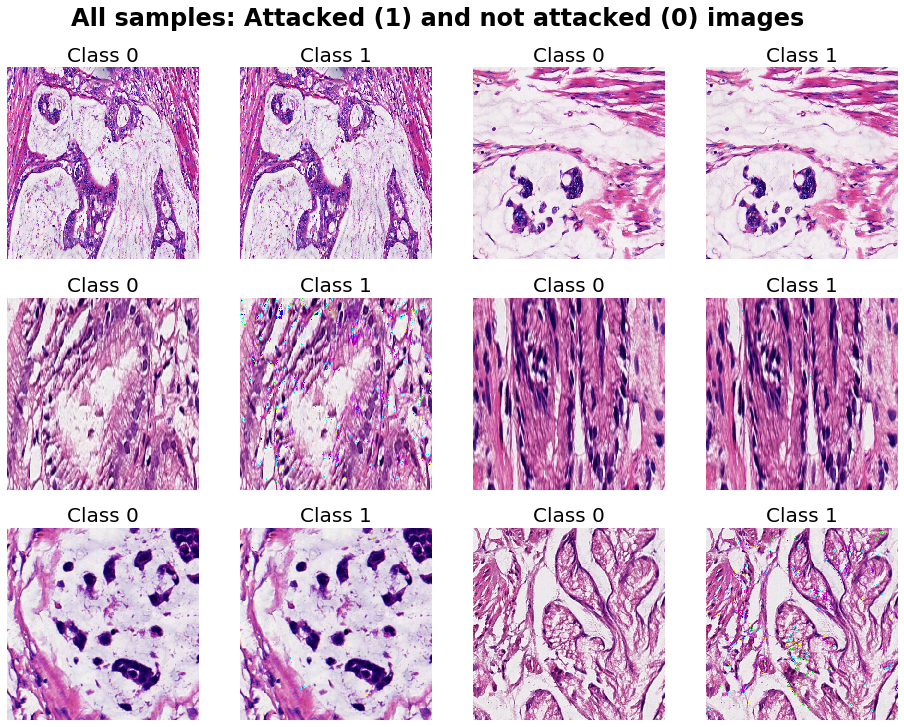

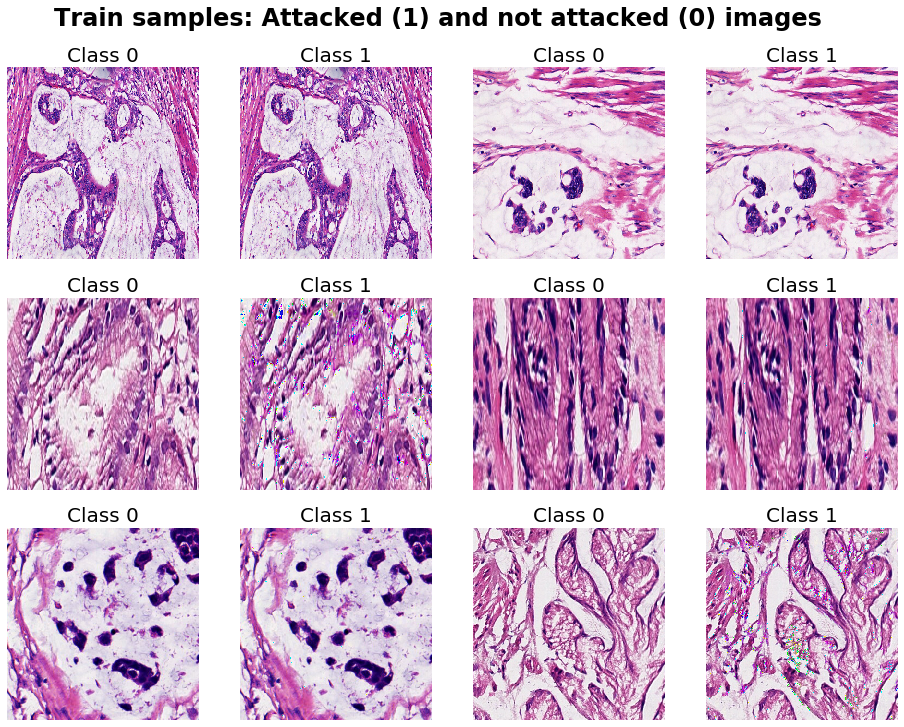

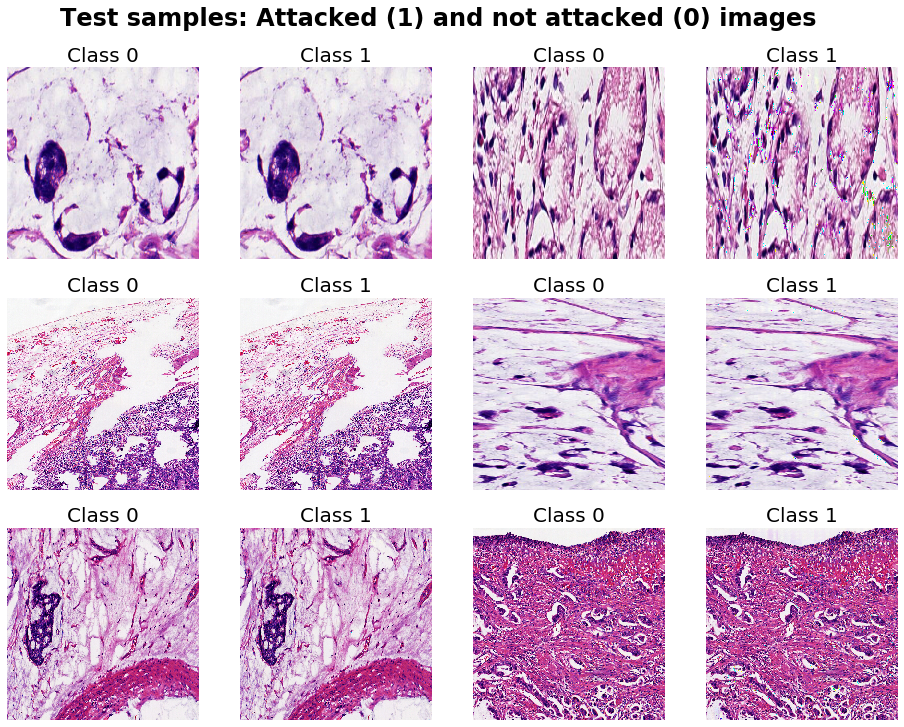

In [13]:
from plot import plot_dataloader

def plot_attacked_examples(dataset_originals, dataset_attacks, rows=3, cols=4, width=4):
    """
    Helper function to plot samples of attacked and original images from datasets.
    """
    # Collect orignal images and attacks in a dataset and change labels to attack (1) and orignal (0)
    dataset = []
    for i, (img, att) in enumerate(zip(dataset_originals, dataset_attacks)):
        img = list(img)
        img[1] = 0
        dataset.append(tuple(img))
        att = list(att)
        att[1] = 1
        dataset.append(tuple(att))

    # Load data into loaders
    dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

    # Plot training data
    fig, axs = plot_dataloader(dataloader, rows=rows, cols=cols, width=width, mean=data_mean, std=data_std)
    return fig


# First load attacks and originals into datasets
dataset_attacks_all = LoadDatasetFromCSV(image_root=ATT_LOAD_PARTITION_ROOT,
                                         csv_path=ATT_LOAD_PARTITION_ROOT+'attacked_images.csv',
                                         transforms=album_compose)
dataset_originals_all = LoadDatasetFromCSV(image_root=ATT_LOAD_PARTITION_ROOT,
                                           csv_path=ATT_LOAD_PARTITION_ROOT+'original_images.csv',
                                           transforms=album_compose)

fig = plot_attacked_examples(dataset_originals_all, dataset_attacks_all, rows=3, cols=4, width=4)
fig.suptitle('All samples: Attacked (1) and not attacked (0) images', fontsize=24, y=0.95, weight='bold')
plt.show()

fig = plot_attacked_examples(dataset_originals_train, dataset_attacks_train, rows=3, cols=4, width=4)
fig.suptitle('Train samples: Attacked (1) and not attacked (0) images', fontsize=24, y=0.95, weight='bold')
plt.show()

fig = plot_attacked_examples(dataset_originals_test, dataset_attacks_test, rows=3, cols=4, width=4)
fig.suptitle('Test samples: Attacked (1) and not attacked (0) images', fontsize=24, y=0.95, weight='bold')
plt.show()

## Detect attacks by output logits of classifier

#### Compute logits of original images and attacked images

In [16]:
def get_model_logits(model, dataloader):
    """
    Helper function to get logit predictions from model.
    """
    # Initialize result tensors
    all_logits = torch.Tensor()
    all_true_labels = torch.Tensor()
    all_pred_labels = torch.Tensor()
    # Iterate over all images and labels in dataloader
    print('Computing logits and labels', end='')
    for batch, (images, labels) in enumerate(dataloader):
        print('.', end='')
        # Set model to evaluation mode
        model.to(device)
        model.eval()
        images = images['image'].to(device)
        # Compute output logits and predicted label for images
        logits = model(images).detach()
        pred_labels = logits.max(1, keepdim=False)[1]
        # Save result for batch to result arrays
        all_logits      = torch.cat((all_logits,      logits),      dim=0)
        all_true_labels = torch.cat((all_true_labels, labels),      dim=0)
        all_pred_labels = torch.cat((all_pred_labels, pred_labels), dim=0)
    print(' done.')
    return all_logits, all_true_labels, all_pred_labels



# Training - Get logits, true labels and predicted labels from model
kd_originals_logits_train, kd_originals_true_labels_train, kd_originals_pred_labels_train = \
    get_model_logits(model, dataloader_originals_train)

kd_attacks_logits_train, kd_attacks_true_labels_train, kd_attacks_pred_labels_train = \
    get_model_logits(model, dataloader_attacks_train)

# Test - Get logits, true labels and predicted labels from model
kd_originals_logits_test, kd_originals_true_labels_test, kd_originals_pred_labels_test = \
    get_model_logits(model, dataloader_originals_test)

kd_attacks_logits_test, kd_attacks_true_labels_test, kd_attacks_pred_labels_test = \
    get_model_logits(model, dataloader_attacks_test)

Computing logits and labels............................................... done.
Computing logits and labels............................................... done.
Computing logits and labels.................... done.
Computing logits and labels.................... done.


#### Clean logits

In [17]:
import scipy



def clean_logits(logits, attacked_logits, true_labels, pred_labels, attacked_labels, softmax=False):
    """
    Helper function to clean out samples which were misclassified from start and unsuccessfully attacked.
    """
    # Initialize list with indicides to use
    idxs = []
    counter = 0
    for i in range(len(logits)):
        # Only consider indices that were correcrtly classified from start and successfully attacked
        if ((true_labels[i]==pred_labels[i]) and (true_labels[i]!=attacked_labels[i])):
            idxs.append(i)
        else:
            idxs.append(i)
            counter += 1
    if softmax:
        logits = scipy.special.softmax(logits, axis=1)
        attacked_logits = scipy.special.softmax(logits, axis=1)
#     print('Removed', counter, 'samples')
    # Return cleaned arrays
    return logits[idxs], attacked_logits[idxs], true_labels[idxs], pred_labels[idxs], attacked_labels[idxs]



# Print results of getting logits
print('Accuracy (train):             ', 100*(torch.sum(kd_originals_true_labels_train==kd_originals_pred_labels_train) \
      /kd_originals_true_labels_train.shape[0]).item())
print('Accuracy after attack (train):', 100*(torch.sum(kd_originals_true_labels_train==kd_attacks_pred_labels_train) \
      /kd_attacks_pred_labels_train.shape[0]).item())
print('')

print('Acuracy (test):               ', 100*(torch.sum(kd_originals_true_labels_test==kd_originals_pred_labels_test) \
      /kd_originals_true_labels_test.shape[0]).item())
print('Accuracy after attack (test): ', 100*(torch.sum(kd_originals_true_labels_test==kd_attacks_pred_labels_test) \
      /kd_attacks_pred_labels_test.shape[0]).item())
print('')


# Training - Clean data
(kd_originals_logits_train_cleaned,
kd_attacks_logits_train_cleaned,
kd_originals_true_labels_train_cleaned,
kd_originals_pred_labels_train_cleaned,
kd_attacks_pred_labels_train_cleaned) = \
    clean_logits(logits=kd_originals_logits_train,
                 attacked_logits=kd_attacks_logits_train,
                 true_labels=kd_originals_true_labels_train,
                 pred_labels=kd_originals_pred_labels_train,
                 attacked_labels=kd_attacks_pred_labels_train,
                 softmax=False)

# Testing - Clean data
(kd_originals_logits_test_cleaned,
kd_attacks_logits_test_cleaned,
kd_originals_true_labels_test_cleaned,
kd_originals_pred_labels_test_cleaned,
kd_attacks_pred_labels_test_cleaned) = \
    clean_logits(logits=kd_originals_logits_test,
                 attacked_logits=kd_attacks_logits_test,
                 true_labels=kd_originals_true_labels_test,
                 pred_labels=kd_originals_pred_labels_test,
                 attacked_labels=kd_attacks_pred_labels_test,
                 softmax=False)

# Print results of getting logits
print('')
print('CLEANED DATA')
print('Accuracy (train):             ', 100*(torch.sum(kd_originals_true_labels_train_cleaned==kd_originals_pred_labels_train_cleaned) \
      /kd_originals_true_labels_train_cleaned.shape[0]).item())
print('Accuracy after attack (train):', 100*(torch.sum(kd_originals_true_labels_train_cleaned==kd_attacks_pred_labels_train_cleaned) \
      /kd_attacks_pred_labels_train_cleaned.shape[0]).item())
print('')

print('Acuracy (test):               ', 100*(torch.sum(kd_originals_true_labels_test_cleaned==kd_originals_pred_labels_test_cleaned) \
      /kd_originals_true_labels_test_cleaned.shape[0]).item())
print('Accuracy after attack (test): ', 100*(torch.sum(kd_originals_true_labels_test_cleaned==kd_attacks_pred_labels_test_cleaned) \
      /kd_attacks_pred_labels_test_cleaned.shape[0]).item())
print('')


Accuracy (train):              96.23655676841736
Accuracy after attack (train): 51.61290168762207

Acuracy (test):                97.50000238418579
Accuracy after attack (test):  52.49999761581421


CLEANED DATA
Accuracy (train):              96.23655676841736
Accuracy after attack (train): 51.61290168762207

Acuracy (test):                97.50000238418579
Accuracy after attack (test):  52.49999761581421



#### Train and estimate Kernel Density (KD) for logit data

In [18]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate



class Detect:
    def __init__(self, name, classes=(0,1,2)):
        self.name = name
        self.classes = classes
        self.models = {}

class KernelDensityEstimation(Detect):
    def __init__(self, classes=(0,1,2), bandwidth=1.0):
        super().__init__('KDE', classes=(0,1,2))
        self.bandwidth = bandwidth
        self.bandwidths = {}
        
    def train(self, data, labels, print_info=False):
        """
        Train KDE for all classes.
        """
        print('Training KDE on features for each class', end='')
        # Initialize dict with indices for each class used to train each KDE for each class
        idxs = {}
        scores = {}
        for c in self.classes:
            # Get indices for current class c
            idxs[c] = np.where(labels==c)[0]
            # Flatten data of "image" to 1D
            c_data = torch.flatten(data[idxs[c]].detach(), start_dim=1)
            # Initialize KernelDensity and fit to data of current class c
            self.models[c] = KernelDensity(kernel='gaussian', bandwidth=self.bandwidths[c])
            self.models[c].fit(c_data)
            scores[c] = self.models[c].score(c_data)
            # Print info
            if print_info:
                if c == 0: print('')
                print('Class', c,
                      '  Min:',  np.around(c_data.min().item(), 5),
                      '  Mean:', np.around(c_data.mean().item(), 5),
                      '  Max:',  np.around(c_data.max().item(), 5))
        print('done.')
        # Return models and indices for each class c = (0,1,...)
        return self.models, idxs, scores
    
    def optimize_bandwidth(self, data, labels, bandwidths, num_cv_folds=5):
        """
        Optimize bandwidth of KernelDensity using cross validation on training data.
        """
        scores = {}
        for c in self.classes:
            # Extract indices for current class
            idxs = np.where(labels==c)[0]
            # Define parameters to test for in search grid
            param_grid =  {'bandwidth':bandwidths[c]}
            # Define search grid with KernelDensity, parameters and number of folds
            grid = GridSearchCV(KernelDensity(), param_grid=param_grid, cv=num_cv_folds, verbose=1)
            # Prepare data and use grid search
            c_data = torch.flatten(data[idxs].detach(), start_dim=1).numpy()
            grid.fit(c_data)
            # Extract best bandwidth
            self.bandwidths[c] = grid.best_params_['bandwidth']
            # Save scores
            scores[c] = grid.best_score_
        # Return best bandwidths
        return self.bandwidths, scores
    
    def test(self, data, labels):
        """
        Test inputted data agains models.
        """
        print('Testing KDE on features for each class ', end='')
        # Initialize dict for scores of each samples for each class
        scores = torch.Tensor()
        for i, (dat, lbl) in enumerate(zip(data, labels)):
            c = int(lbl.item())
            dat = dat.reshape(1,-1)
            score = torch.Tensor(self.models[c].score_samples(dat))
            scores = torch.cat((scores, score), dim=0)
        print('done.')
        return scores
    
    
def print_kd_results(scores, scores_attacks, true_labels, attacks_pred_labels):
    """
    Function to print results for kd testing.
    """
    # Sort data by true class label
    sort_idxs = torch.argsort(true_labels)
    scores = scores[sort_idxs]
    scores_attacks = scores_attacks[sort_idxs]
    true_labels = true_labels[sort_idxs]
    attacks_pred_labels = attacks_pred_labels[sort_idxs]
    # Print means for each class
    for c in (0,1,2):
        c_idxs = np.where(true_labels==c)[0]
        print('Class '+str(c))
        print('  True:     '+str(np.around(scores[c_idxs].mean().item(), 3))+
              ' +- '+str(np.around(2*scores[c_idxs].std().item(), 3)))
        print('  Attacked: '+str(np.around(scores_attacks[c_idxs].mean().item(), 3))+
              ' +- '+str(np.around(2*scores_attacks[c_idxs].std().item(), 3)))
    print('')
    
    # Initialize output format and print headers
    out = "  #{:<3}   {:<10}   {:<18}   {:<8}   {:<20}   {:<10}"
    print(out.format('', 'True label', 'Label after attack', 'Score', 'Score when attacked', 'Diff (%)'))
    # Iterate over all data and print results
    for i, (score, score_attack, true_label, attack_pred_label) in enumerate(zip(
        scores, scores_attacks, true_labels, attacks_pred_labels)):
        diff = (score-score_attack)/score
        print(out.format(i+1,
                         int(true_label.item()),
                         int(attack_pred_label.item()),
                         np.around(score.item(), 3),
                         np.around(score_attack.item(), 3),
                         np.around(diff.item(), 1)))

        
        
        
    
# Initialize kernel density estimator
kde = KernelDensityEstimation()



# Find optimal bandwidth according to test feature data
bandwidths_search = [np.linspace(0.1, 5, 5000), np.linspace(0.1, 5, 5000), np.linspace(0.1, 5, 5000)]
try:
    opt_bandwidths, opt_scores
except NameError:
    opt_bandwidths, opt_scores = kde.optimize_bandwidth(data=kd_originals_logits_train_cleaned,
                                                        labels=kd_originals_true_labels_train_cleaned,
                                                        bandwidths=bandwidths_search)
kde.bandwidths = opt_bandwidths
print('Optimal bandwidths:', kde.bandwidths)
print('Optimal scores:    ', opt_scores)
print('')



# Train KDEs
kd_train, kd_idxs_train, kd_scores_train = kde.train(kd_originals_logits_train_cleaned,
                                                     kd_originals_true_labels_train_cleaned,
                                                     print_info=True)
print('')



# Get scores of train data
kd_scores_train         = kde.test(kd_originals_logits_train_cleaned,
                                   kd_originals_true_labels_train_cleaned)

kd_scores_attacks_train = kde.test(kd_attacks_logits_train_cleaned,
                                   kd_attacks_pred_labels_train_cleaned)


# Get scores of test data
kd_scores_test          = kde.test(kd_originals_logits_test_cleaned,
                                   kd_originals_true_labels_test_cleaned)

kd_scores_attacks_test  = kde.test(kd_attacks_logits_test_cleaned,
                                   kd_attacks_pred_labels_test_cleaned)
print('')



# Print results of train
print('TRAINING')
print_kd_results(kd_scores_train, kd_scores_attacks_train,
                 kd_originals_true_labels_train_cleaned,
                 kd_attacks_pred_labels_train_cleaned)
print('')


# Print results of test
print('TESTING')
print_kd_results(kd_scores_test, kd_scores_attacks_test,
                 kd_originals_true_labels_test_cleaned,
                 kd_attacks_pred_labels_test_cleaned)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
Fitting 5 folds for each of 5000 candidates, totalling 25000 fits
Optimal bandwidths: {0: 0.3911182236447289, 1: 2.1466493298659732, 2: 2.2583916783356672}
Optimal scores:     {0: -54.070135170729955, 1: -61.476469229605826, 2: -146.66857904485533}

Training KDE on features for each class
Class 0   Min: -22.00546   Mean: 1.82196   Max: 17.17523
Class 1   Min: -24.20927   Mean: -2.98743   Max: 11.95293
Class 2   Min: -35.16836   Mean: -6.58146   Max: 19.77751
done.

Testing KDE on features for each class done.
Testing KDE on features for each class done.
Testing KDE on features for each class done.
Testing KDE on features for each class done.

TRAINING
Class 0
  True:     -3.289 +- 0.867
  Attacked: -13.486 +- 48.283
Class 1
  True:     -6.743 +- 1.659
  Attacked: -7.763 +- 2.613
Class 2
  True:     -8.386 +- 1.065
  Attacked: -8.957 +- 3.227

  #      True

#### Classify KD estimates with logistic regression to detect attacks

Ratio of attacked and not attacked images for training: 50.0%
Ratio of attacked and not attacked images for testing:  50.0%

TRAINING
Training attack detection accuracy:                     65.86%



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


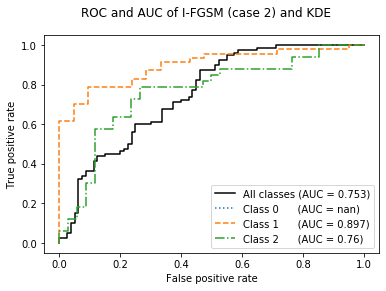

TESTING
Score: 66.25%
FPR:   33.75%
FNR:   33.75%

  #      If attacked   Prediction       Class label   True label    Prob                   Density        
  #0     0             0                0             0             [0.52596 0.47404]      -3.34531       
  #1     0             0                0             0             [0.51905 0.48095]      -4.57538       
  #2     0             0                0             0             [0.52859 0.47141]      -2.87507       
  #3     0             0                0             0             [0.52473 0.47527]      -3.56364       
  #4     0             0                0             0             [0.52746 0.47254]      -3.07703       
  #5     0             0                0             0             [0.52695 0.47305]      -3.16888       
  #6     0             0                0             0             [0.52756 0.47244]      -3.05892       
  #7     0             0                0             0             [0.521 0.479]          -4

In [19]:
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
import sklearn.preprocessing



def get_lr_arrays(scores, scores_attacks, labels, labels_attacks, scale=False, shuffle=False):
    """
    Helper function to prepare KD scores to arrays used for logistic regression
    """
    # Concatenate arrays
    lr_data = torch.cat((scores, scores_attacks), dim=0)
    lr_labels = torch.cat((torch.zeros(len(scores)), torch.ones(len(scores_attacks))), dim=0)
    class_labels = torch.cat((labels, labels_attacks), dim=0)
    true_labels = torch.cat((labels, labels), dim=0)
    
    # Scale to zero mean and one standard deviation
    if scale:
        lr_data = sklearn.preprocessing.scale(lr_data)
        
    # Reshape arrays for logistic regression
    lr_data = lr_data.reshape(-1,1)
    lr_labels = lr_labels.reshape(-1)
    true_labels = true_labels.reshape(-1)
    
    # If to shuffle data
    if shuffle:
        idxs_shuffled = np.random.permutation(len(lr_data))
    else:
        idxs_shuffled = np.arange(0, len(lr_data))
        
    # Return arrays
    return lr_data[idxs_shuffled], lr_labels[idxs_shuffled], class_labels[idxs_shuffled], true_labels[idxs_shuffled]

def print_lr_results(lr, lr_data, lr_labels, labels, true_labels, sort=True):
    """
    Helper function to print results of logistic regression on data.
    """
    # Sort after true labels
    if sort:
        sort_idxs = torch.argsort(labels)
        lr_data = lr_data[sort_idxs]
        lr_labels = lr_labels[sort_idxs]
        labels = labels[sort_idxs]
        true_labels = true_labels[sort_idxs]
        
    # Get results from model and data
    lr_probs = lr.predict_proba(lr_data)
    lr_score = lr.score(lr_data, lr_labels)
    lr_preds = lr.predict(lr_data)
    
    # Compute false positive rate and false negative rate
    p = np.sum((lr_labels==0).numpy())
    n = np.sum((lr_labels==1).numpy())
    fpr = np.sum(np.multiply(lr_labels==1, lr_preds==0).numpy())/n
    fnr = np.sum(np.multiply(lr_labels==0, lr_preds==1).numpy())/p
    
    # Print reuslts
    print('Score: '+str(np.around(lr_score*100, 2))+'%')
    print('FPR:   '+str(np.around(fpr*100, 2))+'%')
    print('FNR:   '+str(np.around(fnr*100, 2))+'%')
    print('')
    out = "  #{:<3}   {:<11}   {:<10}   {:<1}   {:<11}   {:<11}   {:<20}   {:<15}"
    print(out.format('', 'If attacked', 'Prediction', '', 'Class label', 'True label', 'Prob', 'Density'))          
    for i, (lr_dat, lr_lbl, lbl, true_lbl, lr_pred, lr_prob) in enumerate(zip(lr_data, lr_labels, labels, true_labels,
                                                                              lr_preds, lr_probs)):
        print(out.format(i,
                         int(lr_lbl.item()),
                         int(lr_pred.item()),
                         'x' if lr_lbl.item()!=lr_pred.item() else '',
                         int(lbl.item()),
                         int(true_lbl.item()),
                         str(np.around(lr_prob, 5)),
                         np.around(lr_dat.item(), 5)))
    

def plot_roc(lr, data, if_attacked, pred_labels, true_labels):
    classes = (0,1,2)
    fpr = {}
    tpr = {}
    roc_auc = {}
    score = lr.decision_function(data)
    fpr['all'], tpr['all'], _ = roc_curve(if_attacked, score)
    roc_auc['all'] = auc(fpr['all'], tpr['all'])
    for c in classes:
        idxs = np.where(pred_labels==c)[0]
        fpr[c], tpr[c], _ = roc_curve(if_attacked[idxs], score[idxs])
        roc_auc[c] = auc(fpr[c], tpr[c])
    
    fig, ax = plt.subplots()
    label = 'All classes (AUC = ' + str(np.around(roc_auc['all'],3)) +')'
    ax.plot(fpr['all'], tpr['all'], 'k', label=label)
    linestyles = ['dotted', 'dashed', 'dashdot']
    for c in classes:
        label = 'Class ' + str(c) + '      (AUC = ' + str(np.around(roc_auc[c],3)) +')'
        ax.plot(fpr[c], tpr[c], label=label, alpha=1, linestyle=linestyles[c])
    
    ax.legend(loc='lower right')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    fig.suptitle('ROC and AUC of I-FGSM (case 2) and KDE')
    


    
# Print ratio of datasets
print('Ratio of attacked and not attacked images for training: '+
      str(100*len(kd_scores_attacks_train)/(len(kd_scores_attacks_train)+len(kd_scores_train)))+'%')
print('Ratio of attacked and not attacked images for testing:  '+
      str(100*len(kd_scores_attacks_test)/(len(kd_scores_attacks_test)+len(kd_scores_test)))+'%')
print("")



# Get training data and labels for training of logistic regression classifier
lr_logits_train, lr_if_attacked_train, lr_labels_train, true_labels_train = get_lr_arrays(kd_scores_train,
                                                                       kd_scores_attacks_train,
                                                                       kd_originals_true_labels_train_cleaned,
                                                                       kd_attacks_pred_labels_train_cleaned,
                                                                       scale=False, shuffle=False)
lr_logits_test,  lr_if_attacked_test,  lr_labels_test, true_labels_test  = get_lr_arrays(kd_scores_test,
                                                                       kd_scores_attacks_test,
                                                                       kd_originals_true_labels_test_cleaned,
                                                                       kd_attacks_pred_labels_test_cleaned,
                                                                       scale=False, shuffle=False)

# Train logistic regression classifier on training data
print('TRAINING')
lr = LogisticRegressionCV(cv=5)
lr.fit(lr_logits_train, lr_if_attacked_train)
lr_score_train = lr.score(lr_logits_train, lr_if_attacked_train)
print("Training attack detection accuracy:                     "+str(np.around(100*lr_score_train, 2))+'%')
print("")


plot_roc(lr, lr_logits_test, lr_if_attacked_test, lr_labels_test, true_labels_test)
plt.savefig('roc_ifgsm.pdf')
plt.show()


print('TESTING')
# Test logistic regression classifier on test data
print_lr_results(lr, lr_logits_test, lr_if_attacked_test, lr_labels_test, true_labels_test)

# (Alterantive detection with KD, currently not working very well)

## Detect attacks by last layer feature extraction

#### Settings

In [13]:
LOAD_FEATURES = True
LOAD_FEATURES_PATH = './features/2021-11-16/'
SAVE_FEATURES_PATH = './features/2021-11-16/'
MAX_BATCHES = None

#### Compute or load features

In [ ]:
import os
from data import dataloader_to_lists

def get_features(model, dataloader, path, name, load=True, max_batches=None):
    """
    Function to get features from model's last layer.
    """
    if load:
        all_features = torch.load(path+name+'.pt')
        all_features_labels = torch.load(path+name+'_labels'+'.pt')
        print("Loading features for", name, "done.")
    else:
        print("Extracting features for", name, end="")
        
        # Set max_batches to numeber of batches if None
        if max_batches is None:
            max_batches = len(dataloader)
        
        # If save path does not exist, create it
        if not os.path.exists(path):
            os.makedirs(path)

        # Initalize result array
        all_features = torch.Tensor()
        all_features_labels = torch.Tensor()

        # iterate over all batches
        for batch, (images, labels) in enumerate(dataloader):
            
            # Extract image and features
            inputs = images['image'].to(device)
            features = model.extract_features(inputs)
            features = features.detach()
            labels = labels.detach()


            # Append features to result array
            all_features = torch.cat((all_features, features), dim=0)
            all_features_labels = torch.cat((all_features_labels, labels), dim=0)
            
            print(".", end="")
            
            # Stop if above max amount of batches to test for
            if batch >= max_batches - 1:
                break
        
        # Save features
        torch.save(all_features, path+name+'.pt')
        torch.save(all_features_labels, path+name+'_labels'+'.pt')
        
        print(" done.")
    
    return all_features, all_features_labels
        


# Compute or load features from last layer for training and test data as well as adversarial attacks
all_features_train, all_features_train_labels = get_features(model, dataloader=dataloader_originals_train,
             path=LOAD_FEATURES_PATH, name='all_features_train', load=LOAD_FEATURES, max_batches=MAX_BATCHES)

all_features_train_adv, all_features_train_adv_labels = get_features(model, dataloader=dataloader_attacks_train,
             path=LOAD_FEATURES_PATH, name='all_features_train_adv', load=LOAD_FEATURES, max_batches=MAX_BATCHES)

all_features_test, all_features_test_labels = get_features(model, dataloader=dataloader_originals_test,
             path=LOAD_FEATURES_PATH, name='all_features_test', load=LOAD_FEATURES, max_batches=MAX_BATCHES)

all_features_test_adv, all_features_test_adv_labels = get_features(model, dataloader=dataloader_attacks_test,
             path=LOAD_FEATURES_PATH, name='all_features_test_adv', load=LOAD_FEATURES, max_batches=MAX_BATCHES)

#### Clean features
Remove samples which did not get classified correctly initially or if attack was unsuccessful.

In [ ]:
# Get initial labels predicted by model for test original images
try:
    all_features_test_init_labels
except NameError:
    print('all_features_test_init_labels was not defined, so calculate the initial labels predicted by the model')
    all_features_test_init_labels = torch.Tensor()
    for (imgs, lbls) in dataloader_originals_test:
        print('.', end='')
        model.eval()
        imgs = imgs['image'].to(device)
        preds = model(imgs)
        preds = preds.detach()
        preds = torch.max(preds, 1)[1]
        all_features_test_init_labels = torch.cat((all_features_test_init_labels, preds), dim=0)
    print(' done.')
        
# Get initial labels predicted by model for test original images
try:
    all_features_train_init_labels
except NameError:
    print('all_features_train_init_labels was not defined, so calculate the initial labels predicted by the model')
    all_features_train_init_labels = torch.Tensor()
    for (imgs, lbls) in dataloader_originals_train:
        print('.', end='')
        model.eval()
        imgs = imgs['image'].to(device)
        preds = model(imgs)
        preds = preds.detach()
        preds = torch.max(preds, 1)[1]
        all_features_train_init_labels = torch.cat((all_features_train_init_labels, preds), dim=0)
    print(' done.')

# Remove unwanted samples
def remove_features(features, att_features, true_labels, init_labels, att_labels):
    idxs = []
    for i in range(len(features)):
        if ((true_labels[i]==init_labels[i]) and (true_labels[i]!=att_labels[i])):
            idxs.append(i)
    return features[idxs], att_features[idxs], true_labels[idxs], init_labels[idxs], att_labels[idxs]

all_features_train_cleaned, all_features_train_adv_cleaned, all_features_train_labels_cleaned, \
    all_features_train_init_labels_cleaned, all_features_train_adv_labels_cleaned = remove_features(
        all_features_train,
        all_features_train_adv,
        all_features_train_labels,
        all_features_train_init_labels,
        all_features_train_adv_labels)

all_features_test_cleaned, all_features_test_adv_cleaned, all_features_test_labels_cleaned, \
    all_features_test_init_labels_cleaned, all_features_test_adv_labels_cleaned = remove_features(
        all_features_test,
        all_features_test_adv,
        all_features_test_labels,
        all_features_test_init_labels,
        all_features_test_adv_labels)

#### Train KD

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate



class Detect:
    def __init__(self, name, classes=(0,1,2)):
        self.name = name
        self.classes = classes
        self.models = {}

class KernelDensityEstimation(Detect):
    def __init__(self, classes=(0,1,2), bandwidth=1.0):
        super().__init__('KDE', classes=(0,1,2))
        self.bandwidth = bandwidth
        self.bandwidths = {}
        
    def train(self, data, labels, print_info=False):
        """
        Train KDE for all classes.
        """
        print('Training KDE on features for each class', end='')
        # Initialize dict with indices for each class used to train each KDE for each class
        idxs = {}
        scores = {}
        for c in self.classes:
            # Get indices for current class c
            idxs[c] = np.where(labels==c)[0]
            # Flatten data of "image" to 1D
            c_data = torch.flatten(data[idxs[c]].detach(), start_dim=1)
            # Initialize KernelDensity and fit to data of current class c
            self.models[c] = KernelDensity(kernel='gaussian', bandwidth=self.bandwidths[c])
            self.models[c].fit(c_data)
            scores[c] = self.models[c].score(c_data)
            # Print info
            if print_info:
                if c == 0: print('')
                print('Class', c,
                      '  Min:',  np.around(c_data.min().item(), 5),
                      '  Mean:', np.around(c_data.mean().item(), 5),
                      '  Max:',  np.around(c_data.max().item(), 5))
        print('done.')
        # Return models and indices for each class c = (0,1,...)
        return self.models, idxs, scores
    
    def optimize_bandwidth(self, data, labels, bandwidths, num_cv_folds=5):
        """
        Optimize bandwidth of KernelDensity using cross validation on training data.
        """
        for c in self.classes:
            # Extract indices for current class
            idxs = np.where(labels==c)[0]
            # Define parameters to test for in search grid
            param_grid =  {'bandwidth':bandwidths[c]}
            # Define search grid with KernelDensity, parameters and number of folds
            grid = GridSearchCV(KernelDensity(), param_grid=param_grid, cv=num_cv_folds, verbose=3)
            # Prepare data and use grid search
            c_data = torch.flatten(data[idxs].detach(), start_dim=1).numpy()
            grid.fit(c_data)
            # Extract best bandwidth
            self.bandwidths[c] = grid.best_params_['bandwidth']
        # Return best bandwidths
        return self.bandwidths
    
    def test(self, data, labels):
        """
        Test inputted data agains models.
        """
        print('Testing KDE on features for each class ', end='')
        # Initialize dict for scores of each samples for each class
        scores = {}
        idxs = {}
        for c in self.classes:
            # Get indices for current class c
            idxs[c] = np.where(labels==c)[0]
            # Flatten data of "image" to 1D
            c_data = torch.flatten(data[idxs[c]].detach(), start_dim=1)
            # Compute scores for all samples in data with model trained for class c
            scores[c] = self.models[c].score_samples(c_data)
        print('done.')
        # Return scores of data for each model trained for class c
        return scores

def print_detect_results(scores, scores_att, true_labels, init_labels, attacked_labels):
    classes = (0,1,2)
    for c in classes:
        score = scores[c]
        score_att = scores_att[c]
        idxs = np.where(true_labels==c)[0]
        true_label = true_labels[idxs]
        attacked_label = attacked_labels[idxs]
        init_label = init_labels[idxs]
        out_format = "{:<3} {:<3} {:<3} {:<3} {:<3} {:<3} {:<3} {:<10} {:<10} {:<10}"
        print(out_format.format('#', 'True', 'Init', '', 'Att', '', '', 'Score', 'Score att', 'Diff (%)'))
        for i, (s, s_att, t_lbl, i_lbl, a_lbl) in enumerate(zip(score, score_att,
                                                                true_label, init_label, attacked_label)):
            t_a_bool = 'x' if t_lbl == a_lbl else ' '
            t_i_bool = 'x' if t_lbl != i_lbl else ' '
            bool_all = 'x' if ((t_a_bool == 'x') or (t_i_bool == 'x')) else ' '
            print(out_format.format(i+1, int(t_lbl), int(i_lbl), t_i_bool, int(a_lbl), t_a_bool, bool_all, int(s),
                                    int(s_att), int(100*(s-s_att)/s)))
        print('')
        


# Initialize kernel density estimator
kde = KernelDensityEstimation()

# Find optimal bandwidth according to test feature data
bandwidths_search = [[0.25, 0.265, 0.28], [0.25, 0.265, 0.28], np.linspace(0.2, 0.6, 10)]
bandwidths_search = [[0.25], [0.25], [0.25]]
try:
    opt_bandwidths
except NameError:
    opt_bandwidths = kde.optimize_bandwidth(data=all_features_train_cleaned, labels=all_features_train_labels_cleaned,
                                           bandwidths=bandwidths_search)
kde.bandwidths = opt_bandwidths
print('Optimal bandwidth:', kde.bandwidths)
print('')

# Train KDEs
kdes_trained, idxs_trained, scores_trained = kde.train(all_features_train_cleaned, all_features_train_labels_cleaned,
                                                      print_info=True)

# Get scores of train data
scores_train = kde.test(all_features_train_cleaned, all_features_train_labels_cleaned)
scores_train_att = kde.test(all_features_train_adv_cleaned, all_features_train_adv_labels_cleaned)

# Get scores of test data
scores_test = kde.test(all_features_test_cleaned, all_features_test_labels_cleaned)
scores_test_att = kde.test(all_features_test_adv_cleaned, all_features_test_adv_labels_cleaned)

print('')
# Print results of train
print_detect_results(scores_train, scores_train_att, all_features_train_labels_cleaned,
                     all_features_train_init_labels_cleaned, all_features_train_adv_labels_cleaned)

# Print results of test
print_detect_results(scores_test, scores_test_att, all_features_test_labels_cleaned,
                     all_features_test_init_labels_cleaned, all_features_test_adv_labels_cleaned)

#### Train logistic regression and test for detection of attacks

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
import sklearn.preprocessing


def get_lr_arrays(scores, scores_att):
    lr_data = torch.Tensor()
    lr_labels = torch.Tensor()
    labels = torch.Tensor()
    for c in (0,1,2):
        lr_data = torch.cat((lr_data,
                             torch.Tensor(scores[c]),
                             torch.Tensor(scores_att[c])), dim=0)
        lr_labels = torch.cat((lr_labels,
                               torch.zeros(len(scores[c])),
                               torch.ones(len(scores_att[c]))), dim=0)
        labels = torch.cat((labels,
                            c*torch.ones(len(scores[c])),
                            c*torch.ones(len(scores_att[c]))), dim=0)

    lr_data = sklearn.preprocessing.scale(lr_data.reshape(-1,1))
    lr_labels = lr_labels.reshape(-1)
    idxs_shuffled = np.random.permutation(len(lr_data))
    return lr_data[idxs_shuffled], lr_labels[idxs_shuffled], labels[idxs_shuffled]


def print_lr_results(lr, lr_data, lr_labels, labels):
    lr_probs = lr.predict_proba(lr_data)
    lr_score = lr.score(lr_data, lr_labels)
    lr_preds = lr.predict(lr_data)
    print('Score: '+str(np.around(lr_score*100, 2))+'%')
    out_format = "#{:<3} {:<3} {:<3} {:<3} {:<3} {:<40} {:<20}"
    print(out_format.format('', 'Att', 'Pred', 'Incorr', 'Label', 'Prob', 'Density'))
    for i, (lr_dat, lr_lbl, lbl, lr_pred, lr_p) in enumerate(zip(lr_data, lr_labels, labels, lr_preds, lr_probs)):
        print(out_format.format(i, int(lr_lbl.item()), int(lr_pred.item()), 'x' if lr_lbl.item()!=lr_pred.item() else '',
                                int(lbl.item()), str(lr_p), lr_dat.item()))
    

print('Ratio of attacked and not attacked images for training:',
      100*len(scores_train_att)/(len(scores_train_att)+len(scores_train)))
print('Ratio of attacked and not attacked images for testing:',
      100*len(scores_test_att)/(len(scores_test_att)+len(scores_test)))
print("")

# Get training data and labels for training of logistic regression classifier
lr_data_train, lr_labels_train, labels_train = get_lr_arrays(scores_train, scores_train_att)
lr_data_test, lr_labels_test, labels_test = get_lr_arrays(scores_test, scores_test_att)

# Train logistic regression classifier on training data
lr = LogisticRegressionCV(cv=5).fit(lr_data_train, lr_labels_train)
print("Training attack detection accuracy "+str(np.around(100*lr.score(lr_data_train, lr_labels_train), 2))+'%')
print("")

# Test logistic regression classifier on test data
lr_data_test, lr_labels_test, labels_test = get_lr_arrays(scores_test, scores_test_att)
print_lr_results(lr, lr_data_test, lr_labels_test, labels_test)